In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import sys
from pathlib import Path

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

sn.set_theme(style="ticks")

$
\begin{aligned}
& \frac{1}{T}\sum_{t, l} w_{t,l} A(c|\alpha_{t,l}) B_1(x_1|\beta_{t,l}) B_2(x_2|\gamma_{t,l}) \\
\end{aligned}
$

In [38]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, label_index[i]]).flatten()
    #print(df[0])
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")
    #print(df[0])
    # Get truth label values (annoying because text is not read as text, should fix)
    if (test == False):
        df["Truth_value"] = data["truth"]
        blue = df["Truth_value"][len(df)-1]
        df["Truth"] = y_labels[1]
        df["Truth_int"] = 1
        #df["Truth"][df["Truth_value"] == green] = "blue"
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = y_labels[0]
        df.loc[mask, "Truth_int"] = 0
    
    # Get estimated probabilities
    df[y_labels[0]] = data["probabilities"][:,0]
    df[y_labels[1]] = data["probabilities"][:,1]
    df[f"P({y_labels[0]}|x)"] = data["probabilities"][:,0]
    df[f"P({y_labels[1]}|x)"] = data["probabilities"][:,1]

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)

    # Get error bars
    df[f"quantile25_{y_labels[0]}"] = data["quantiles"][:, 1, 0]
    df[f"quantile75_{y_labels[0]}"] = data["quantiles"][:, 2, 0]
    df[f"quantile25_{y_labels[1]}"] = data["quantiles"][:, 1, 1]
    df[f"quantile75_{y_labels[1]}"] = data["quantiles"][:, 2, 1]
    
    # Errors are the same
    df["Error"] = df[f"quantile75_{y_labels[0]}"] - df[f"quantile25_{y_labels[0]}"]

    return df

In [57]:
# Custom plot function
def plot_distributions(df):

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=axs[0][0])
    sn.histplot(df_red[["x1", "x2"]], palette=["#ffae9d", "#a82b11"], alpha=0.5, ax=axs[0][1], element="step")
    
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    sn.histplot(df_blue[["x1", "x2"]], palette=["#a6bddb", "#0570b0"], alpha=0.5, ax=axs[1][1], element="step")
    
    # legacy
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    sn.histplot(df_green[["x1", "x2"]], palette=["#a6bddb", "#0570b0"], alpha=0.5, ax=axs[1][1], element="step")
    
    axs[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    axs[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot r1
    sn.histplot(df_red, x="r1", color="red", ax=axs[0][2])
    sn.histplot(df_blue, x="r1", color="blue", ax=axs[1][2])
    sn.histplot(df_green, x="r1", color="blue", ax=axs[1][2])

    axs[0][2].set_xlim(0, 25)
    axs[1][2].set_xlim(0, 25)
    for ax in axs.flatten():
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()

    return fig, ax



In [50]:
def plot_results(df, weight_key, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[weight_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=weight_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax
    


In [51]:
def plot_uncertainties(df, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df["Error"], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                cmap = "viridis")
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Error", 
                    #hue_norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                    #size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                    legend=False)
    
    #ax.set_xlim(-25, 25)
    #ax.set_ylim(-25, 25)

    return ax
    

In [52]:
# Setup

#n_data = [2, 4, 8, 16, 32, 64, 128, 256, 300, 500, 512, 900, 1024, 1200, 1500, 1800, 2048, 2100, 2400, 2700, 3000, 4096]
#n_data = [10, 40, 80, 120, 150, 200, 250, 300, 500, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]
#n_data = [2100]*len(n_samples)
#n_data = [2]
#n_samples = [20, 200, 600, 1000, 1400, 1800]
n_plots = 4
n_samples = 1200
n_data = [250, 2100, 3600, 5000]
n_chains = [10, 10, 10, 10]
folderpath = "inference"

y_labels = ["red", "blue"]
x_labels = ["x1", "x2"]
#x_labels = ["x1", "x2"]
label_index = [0, 1]
#nsamples = 1200
R2 = 7
k_red = 15
k_blue = 5
R1_min = 0
scale = 1
vary_a1 = False
vary_R2 = False #Not adapted for this yet
p_red = 0.5
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

train_n = 50000

trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"

truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"

#trainfile = "train_n_5000_kr9_kb3_s1_vary_a1_False"
#valfile = "val_n_5000_kr9_kb3_s1_vary_a1_False"

testfile = "x1_x2_grid"
weight_key = f"P({y_labels[1]}|x)"

#analysis_folders = [f"{trainfile}/nsamples-{n}_nchains-20_ndata-2100" for n in n_samples]
analysis_folders = [f"{trainfile}/nsamples-1200_nchains-{n_chains[i]}_ndata-{n_data[i]}" for i in range(n_plots)]
valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
train_data = pd.read_csv(f"../data/{trainfile}.csv")
truth_data = pd.read_csv(f"../analytical/{truthfile}.csv")

if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

/tmp/ipykernel_24865/960509404.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn.histplot(df_green[["x1", "x2"]], palette=["#a6bddb", "#0570b0"], alpha=0.5, ax=axs[1][1], element="step")


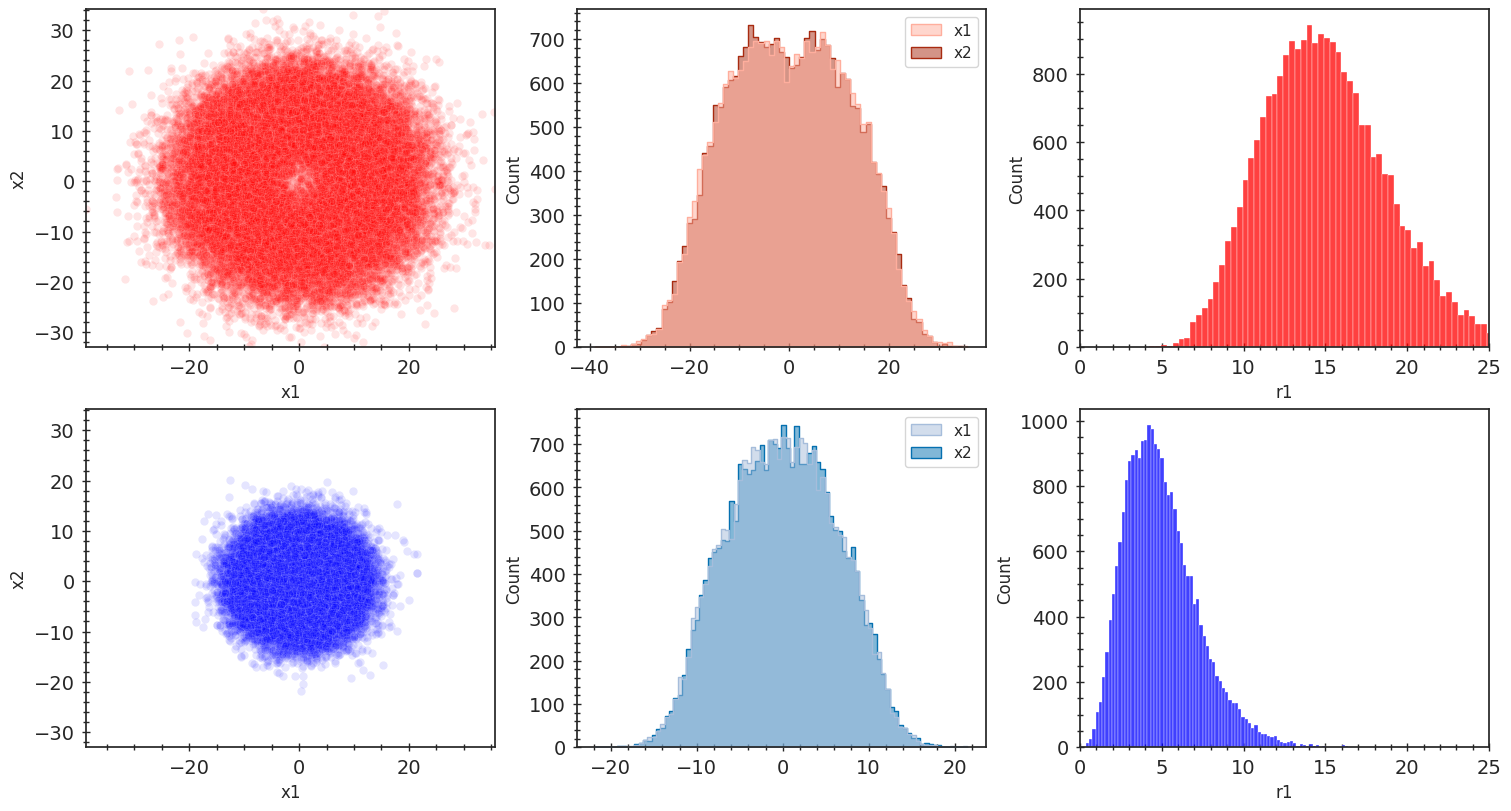

In [58]:
# Plot all training data
fig, ax = plot_distributions(train_data)

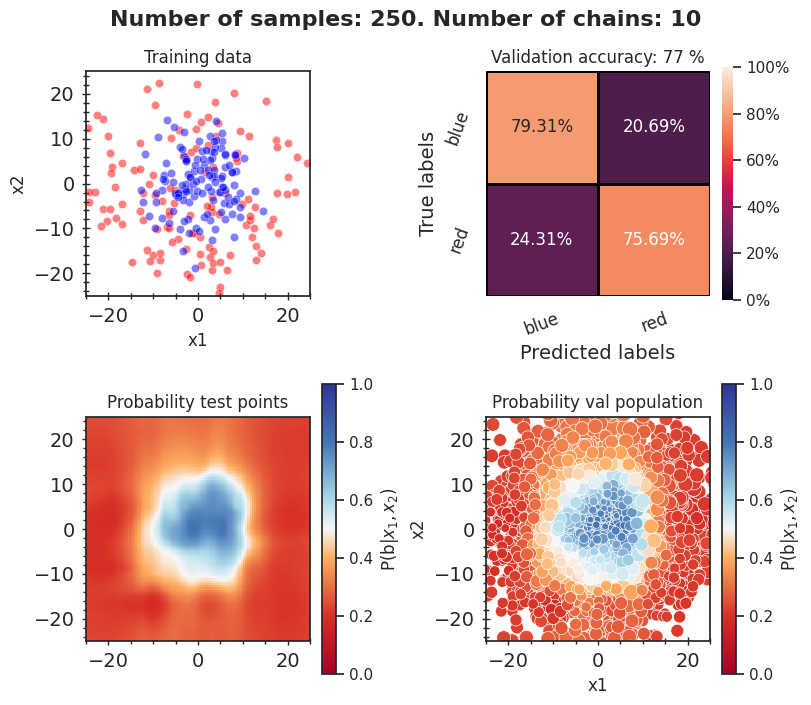

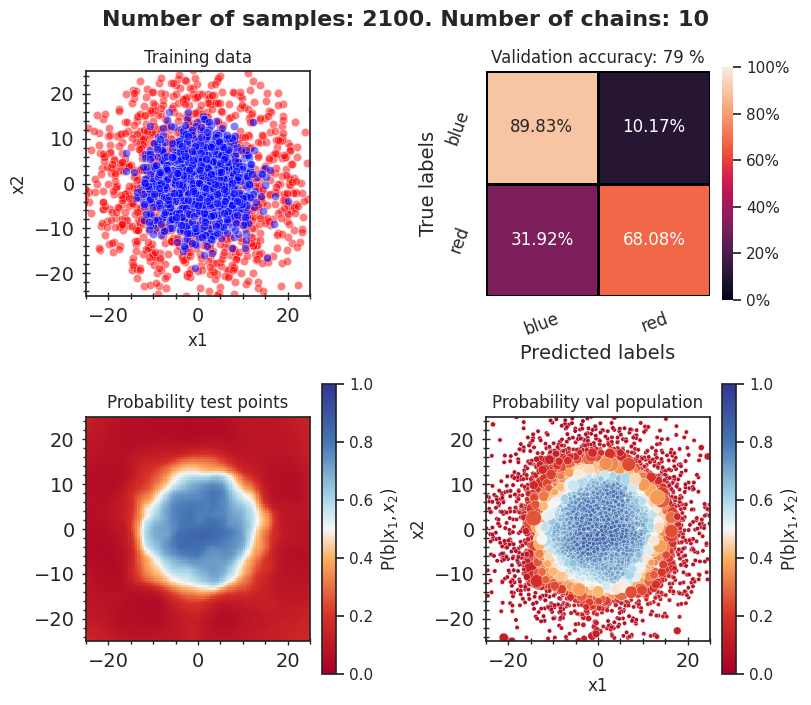

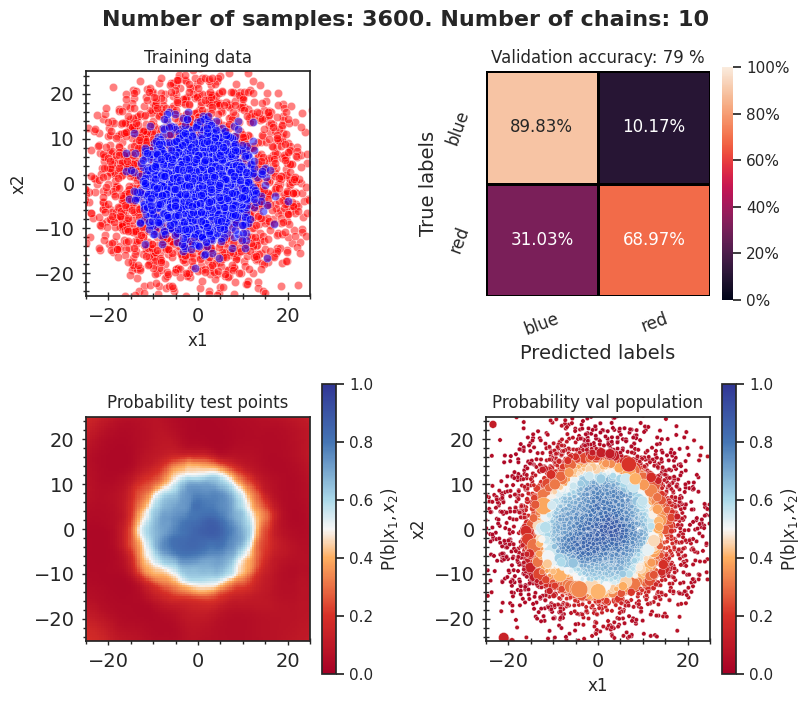

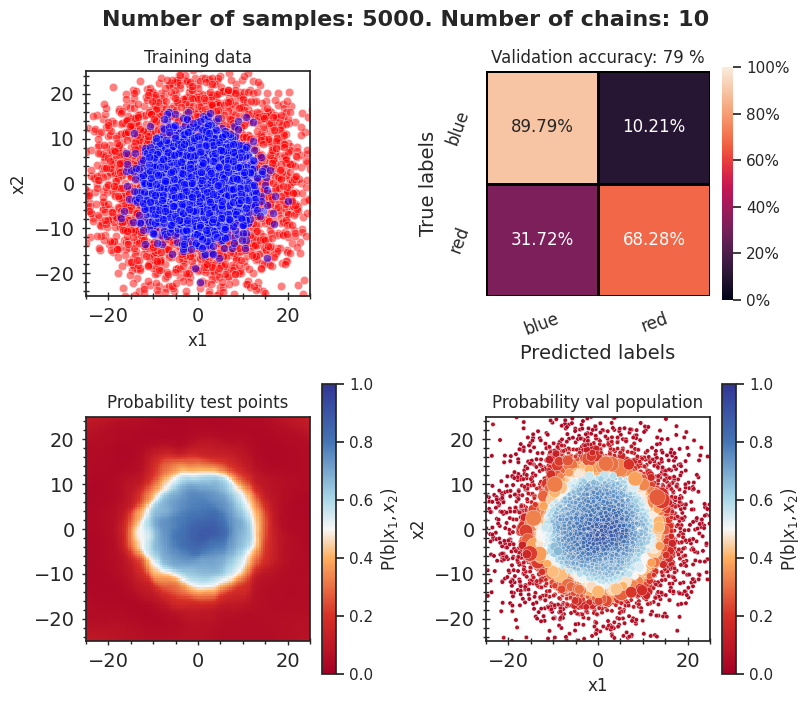

In [54]:

# Plot animation

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    df_val = process_data(valfiles[i], y_labels, x_labels)
    df_test = process_data(testfiles[i], y_labels, x_labels, test=True)
    accuracy = accuracy_score(df_val["Truth"], df_val["Inferred_color"], normalize=True)
    
    #plot data
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0], "Training data")
    axs[0][1] = plot_conf_matrix(df_val, "Truth", "Inferred_color", ["blue", "red"], axs[0][1])
    axs[1][0] = plot_results(df_test, weight_key, axs[1][0], "Probability test points", grid=True)
    axs[1][1] = plot_results(df_val, weight_key, axs[1][1], "Probability val population")
    #axs[2][0] = plot_uncertainties(df_test, axs[2][0], "Error test points", grid=True)
    #axs[2][1] = plot_uncertainties(df_val, axs[2][1], "Error train data")
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(b|$x_1, x_2$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(b|$x_1, x_2$)', ax=axs[1][1])
    #hue_norm_error = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_error, cmap="viridis"), label=r'Error', ax=axs[2][0])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "green"], axs[1][2])

    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains[i]}", size=16, fontweight="bold")
    #plt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

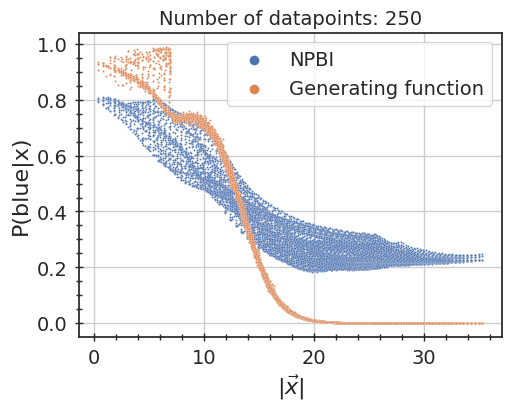

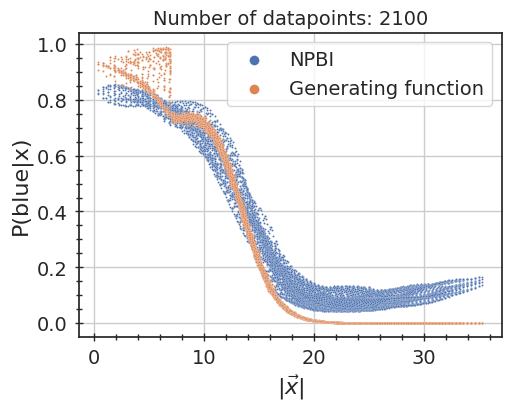

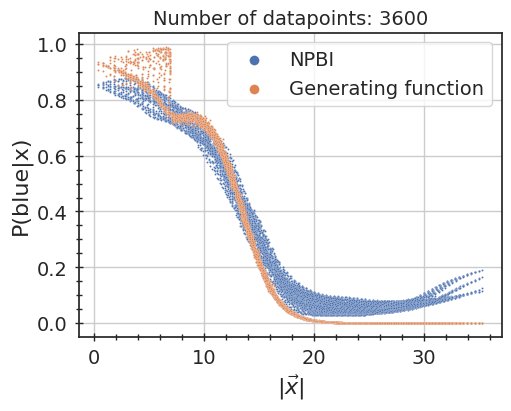

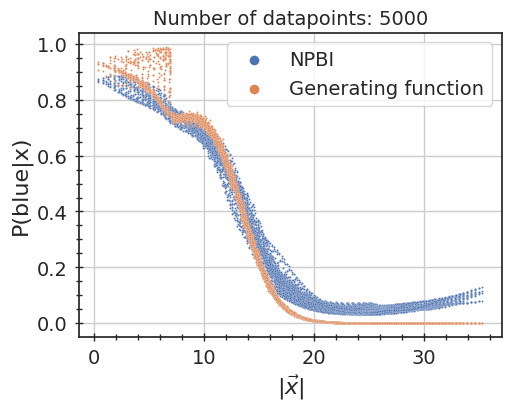

In [60]:
for i in range(len(n_data)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
    df_test = process_data(testfiles[i], y_labels, x_labels, test=True)
    sn.scatterplot(df_test, x="r_x", y="P(blue|x)", s=2, ax = ax, label="NPBI")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
    ax.set_title(f"Number of datapoints: {n_data[i]}", fontsize=14)
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.set_ylabel(r"P(blue|x)", fontsize=16)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()


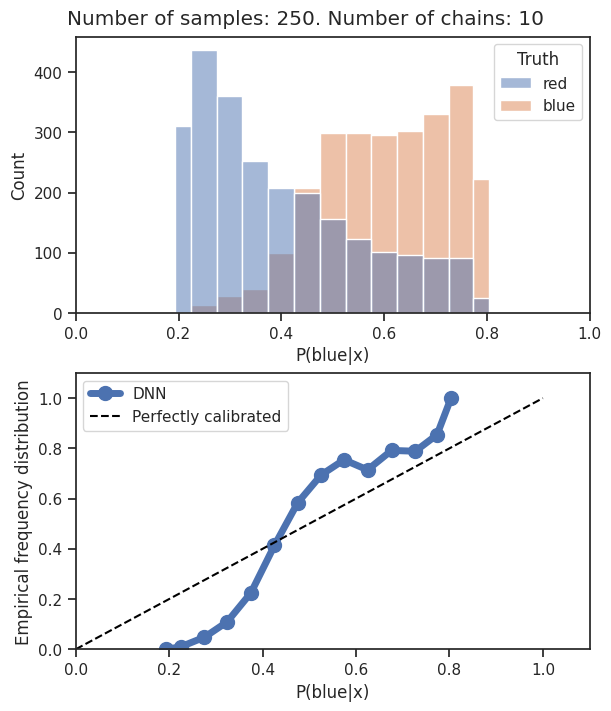

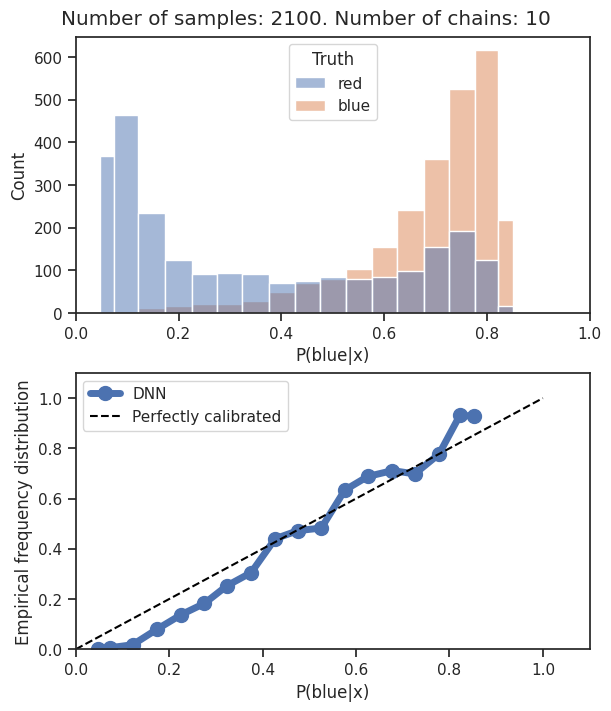

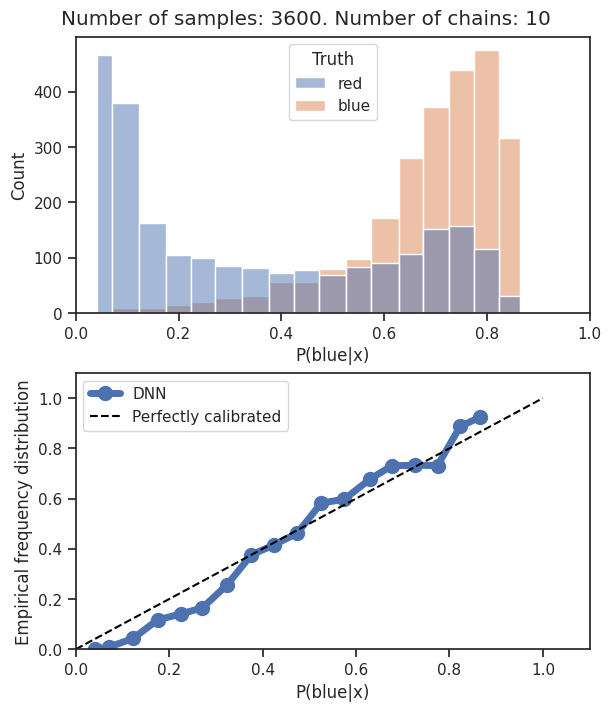

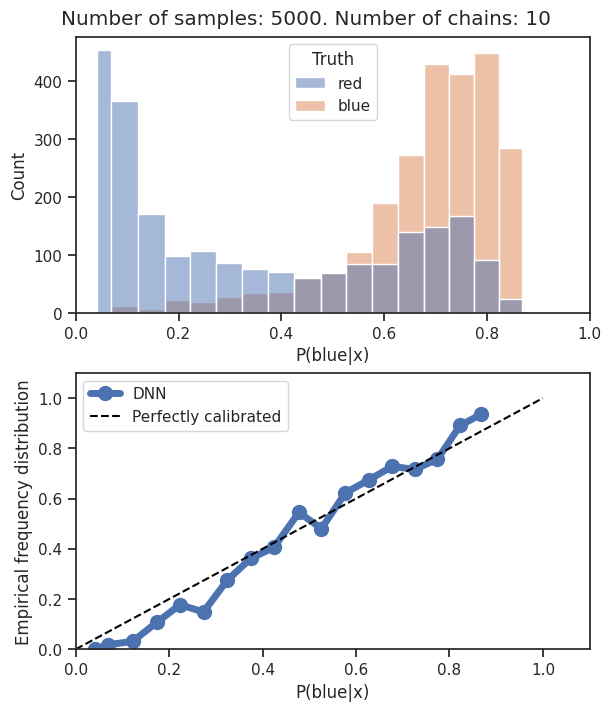

In [56]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(len(n_data)):
    #Get confidence for red
    val_data = process_data(valfiles[i], y_labels, x_labels)

    prob_cal, prob_pred = calibration_curve(val_data["Truth_int"], val_data["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(val_data, x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains[i]}")